In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('mode.chained_assignment', None)

# Data preprocessing

In [2]:
item_to_id = pd.read_csv('item_to_id.csv')
item_to_id_dict = item_to_id.set_index('Item_id')['Item_name'].to_dict()
purchase_history = pd.read_csv('purchase_history.csv')

In [3]:
from collections import Counter

values = purchase_history['id'].apply(lambda x: pd.Series(Counter([int(y) for y in x.split(',')])))
wide_table = purchase_history[['user_id']]
wide_table = wide_table.merge(values, how='left', left_index=True, right_index=True)
wide_table = wide_table.fillna(0)
wide_table = wide_table.groupby('user_id').sum()
wide_table = wide_table.astype(int)

**The top 10 customer who bought the most items overall in her lifetime**

In [4]:
wide_table.sum(axis=1).sort_values(ascending=False).head()

user_id
269335    72
367872    70
599172    64
397623    64
377284    63
dtype: int64

**For each item, the customer who bought that product the most and the number of puchases**

In [5]:
wide_table.apply(lambda x: pd.Series([x.argmax(), x.max()], index=["customer", "max_count"])).T.merge(item_to_id, how='left', 
                                                                 left_index=True, right_on = 'Item_id')

,customer,max_count,Item_name,Item_id
18,512,4,sugar,1
35,512,5,lettuce,2
47,2552,4,pet items,3
46,92,3,baby items,4
20,3605,3,waffles,5
23,5555,4,poultry,6
41,2926,3,sandwich bags,7
15,2493,3,butter,8
3,4445,4,soda,9
32,10238,4,carrots,10


In [24]:
wide_table.columns = [item_to_id_dict[x] for x in wide_table.columns]

**Lettuce was the most popular item.**

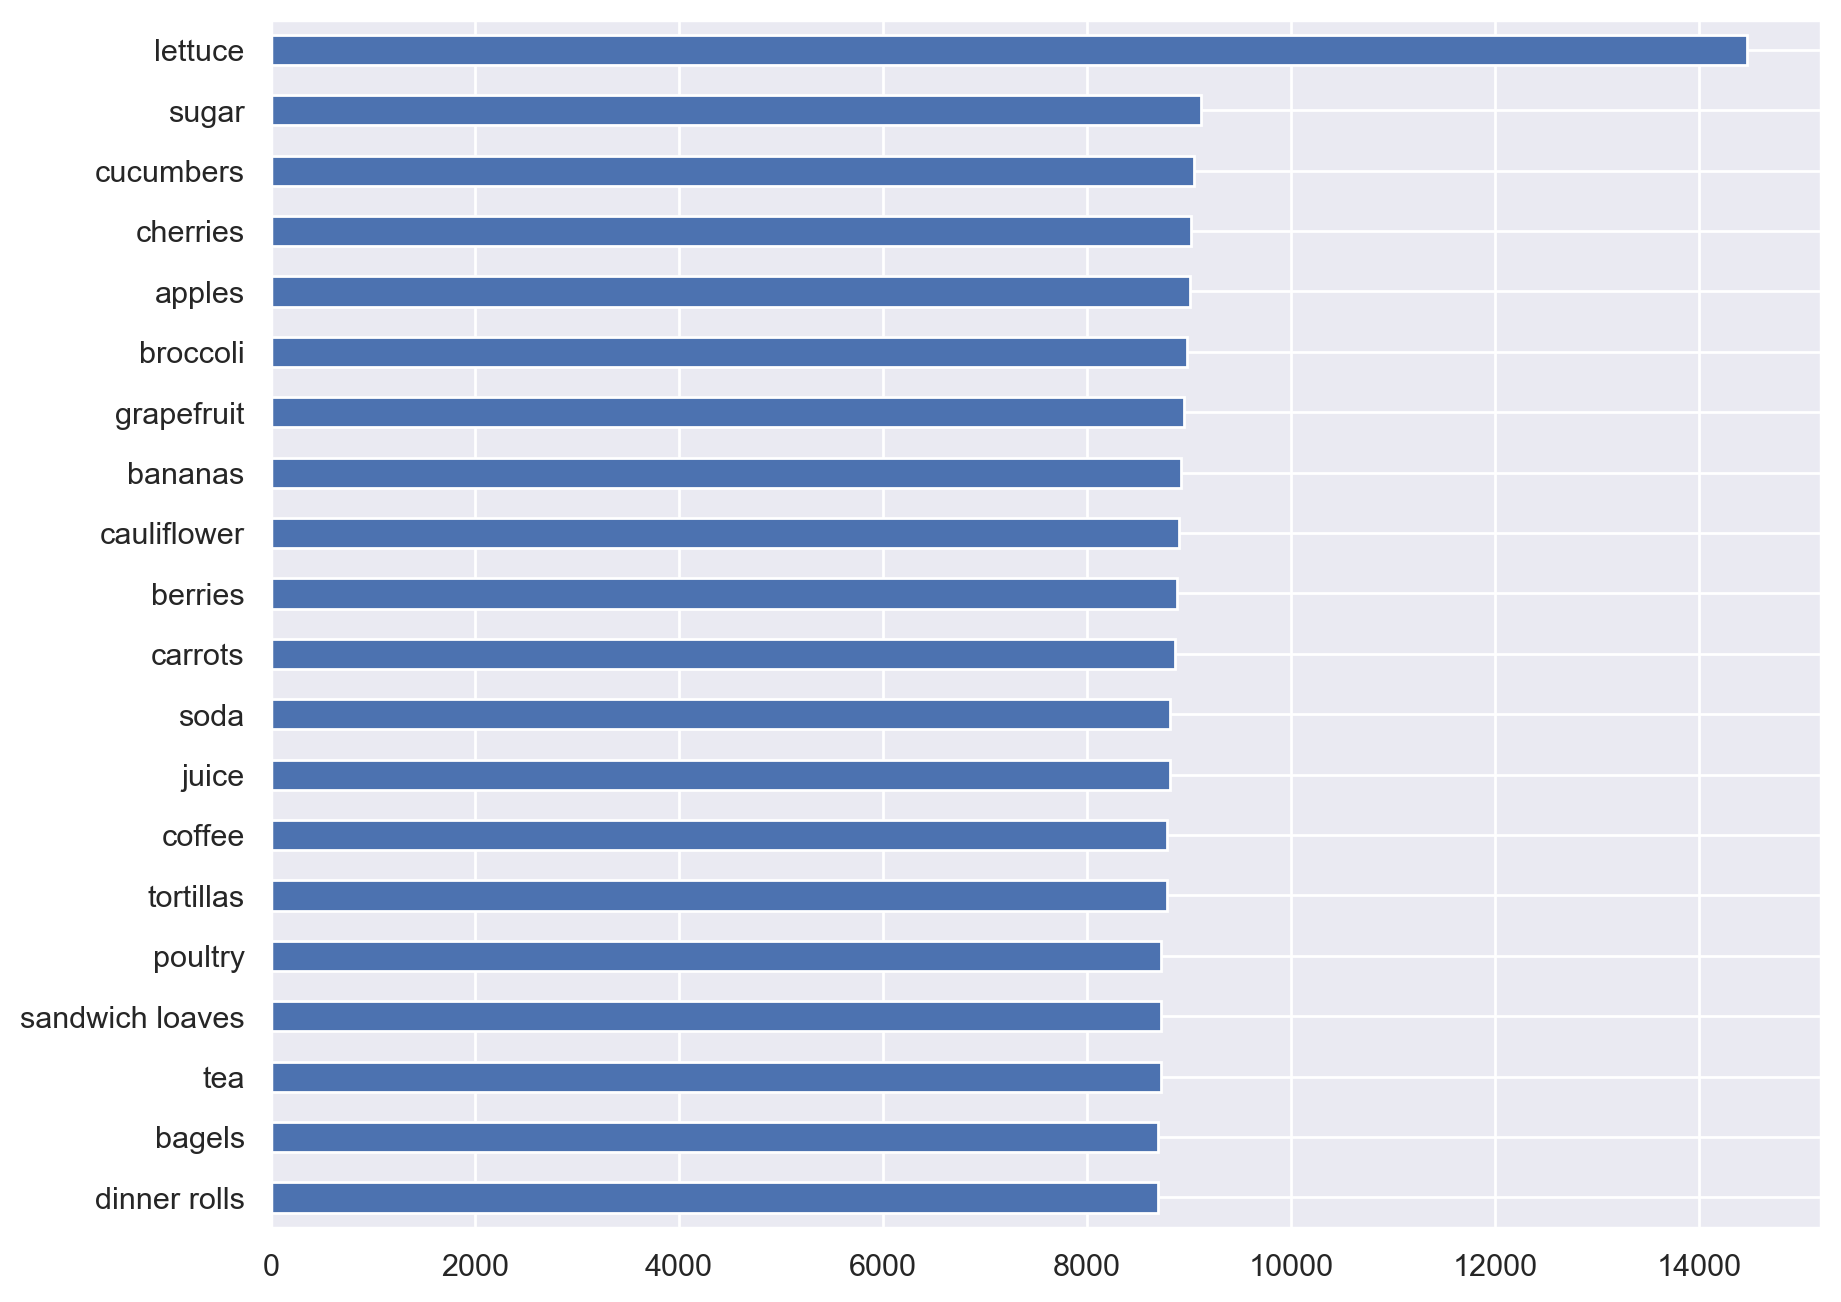

In [95]:
fig, ax = plt.subplots(figsize=(10, 8))
temp = wide_table.T.sum(axis=1).sort_values().tail(20)
temp.plot(kind='barh');

# Apriori Algorithm

**Brief introduction of the algorithm:**

Apriori algorithm is one of the classic approach for solving association problems like which items should be displayed together, one of the most well-known example would be the diaper and beer problem. The core idea of this algorithm is to find a rule that implies the relationship between different items. Specifically, the algorithm is inferencing the probability of items bought together computing by the degree of support and the degree of confidence, which is defined in the following.

- **Confidence: How often items in Y appear in transactions that contain X.**
- **Support: Fraction of transactions that contain both X and Y.**

In [6]:
class Apriori():
    
    def __init__(self, min_support, min_confidence):
        
        self.min_support = min_support
        self.min_confidence = min_confidence
        
    def count(self, purchase_history):
        
        purchase_history['items'] = purchase_history['id'].apply(lambda x: ','.join([item_to_id_dict[int(i)] for i in x.split(',')]))
        
        self.total = 0
        items = {}
        
        for i in range(len(purchase_history)):
            self.total += 1
            for i in purchase_history.iloc[i]['items'].split(','):
                if i in items:
                    items[i] += 1
                else:
                    items[i] = 1
                    
        self.items = {i:j/self.total for i,j in items.items() if j/self.total > self.min_support}
        self.item2id = {j:i for i,j in enumerate(self.items)}
        self.D = np.zeros((self.total, len(items)), dtype=bool)
        
        for n,l in enumerate(purchase_history['items'].values):
            for i in l.strip().split(','):
                if i in self.items:
                    self.D[n, self.item2id[i]] = True
                    
    def find_rules(self, purchase_history):
        
        self.count(purchase_history)
        rules = [{(i,):j for i,j in self.items.items()}]
        l = 0
        
        while rules[-1]:
            rules.append({})
            keys = sorted(rules[-2].keys())
            num = len(rules[-2])
            l += 1
            for i in range(num):
                for j in range(i+1, num):
                    if keys[i][:l-1] == keys[j][:l-1]:
                        _ = keys[i] + (keys[j][l-1], )
                        _id = [self.item2id[k] for k in _]
                        support = 1. * sum(np.prod(self.D[:,_id], 1)) / self.total
                        if support > self.min_support:
                            rules[-1][_] = support
                            
        result = {}
        for n, relu in enumerate(rules[1:]):
            for r,v in relu.items():
                for i, _ in enumerate(r):
                    x = r[:i] + r[i+1:]
                    confidence = v / rules[n][x]
                    if confidence > self.min_confidence:
                        result[x+(r[i],)] = (round(v, 4), round(confidence, 2))
                        
        result = sorted(result.items(), key=lambda x: (-x[1][1], -x[1][0]))
    
        return result

In [7]:
from pprint import pprint

model = Apriori(0.005, 0.6)
clusters = model.find_rules(purchase_history) 
print("Top 10 Clusters: ")
print("--------------------------------------------------------------------------------------------------")
pprint(clusters[:10])

Top 10 Clusters: 
--------------------------------------------------------------------------------------------------
[(('broccoli', 'carrots', 'cauliflower', 'tortillas', 'lettuce'),
  (0.0057, 0.67)),
 (('bagels', 'broccoli', 'cauliflower', 'cucumbers', 'lettuce'),
  (0.0062, 0.66)),
 (('bagels', 'broccoli', 'carrots', 'cucumbers', 'lettuce'), (0.0058, 0.66)),
 (('broccoli', 'cauliflower', 'cucumbers', 'tea', 'lettuce'), (0.0061, 0.65)),
 (('broccoli', 'cauliflower', 'cucumbers', 'dinner rolls', 'lettuce'),
  (0.006, 0.65)),
 (('broccoli', 'carrots', 'cucumbers', 'dinner rolls', 'lettuce'),
  (0.0054, 0.65)),
 (('broccoli', 'cauliflower', 'cucumbers', 'sugar', 'lettuce'), (0.0058, 0.64)),
 (('broccoli', 'carrots', 'cucumbers', 'tortillas', 'lettuce'), (0.0056, 0.64)),
 (('broccoli', 'carrots', 'cucumbers', 'tea', 'lettuce'), (0.0055, 0.64)),
 (('berries', 'broccoli', 'carrots', 'cucumbers', 'lettuce'), (0.0053, 0.64))]


# Visualization

- **The algorithm shows that broccoli, carrots, cauliflower, tortillas and lettuce are often bought together.**
- **People who purchased broccoli were more likely to buy other vegetables and fruits, so it makes sense to put broccoli and the others in the same section.**
- **It also suggests that tea, bagels, dinner rolls, sugar, sandwich loaves ofen showed in the consumers' basket along with other vegetables aforementioned.**

In [8]:
clusters_df = pd.DataFrame(clusters, columns=['cluster', 'confidence'])
clusters_df['confidence'] = clusters_df['confidence'].apply(lambda x: x[1])

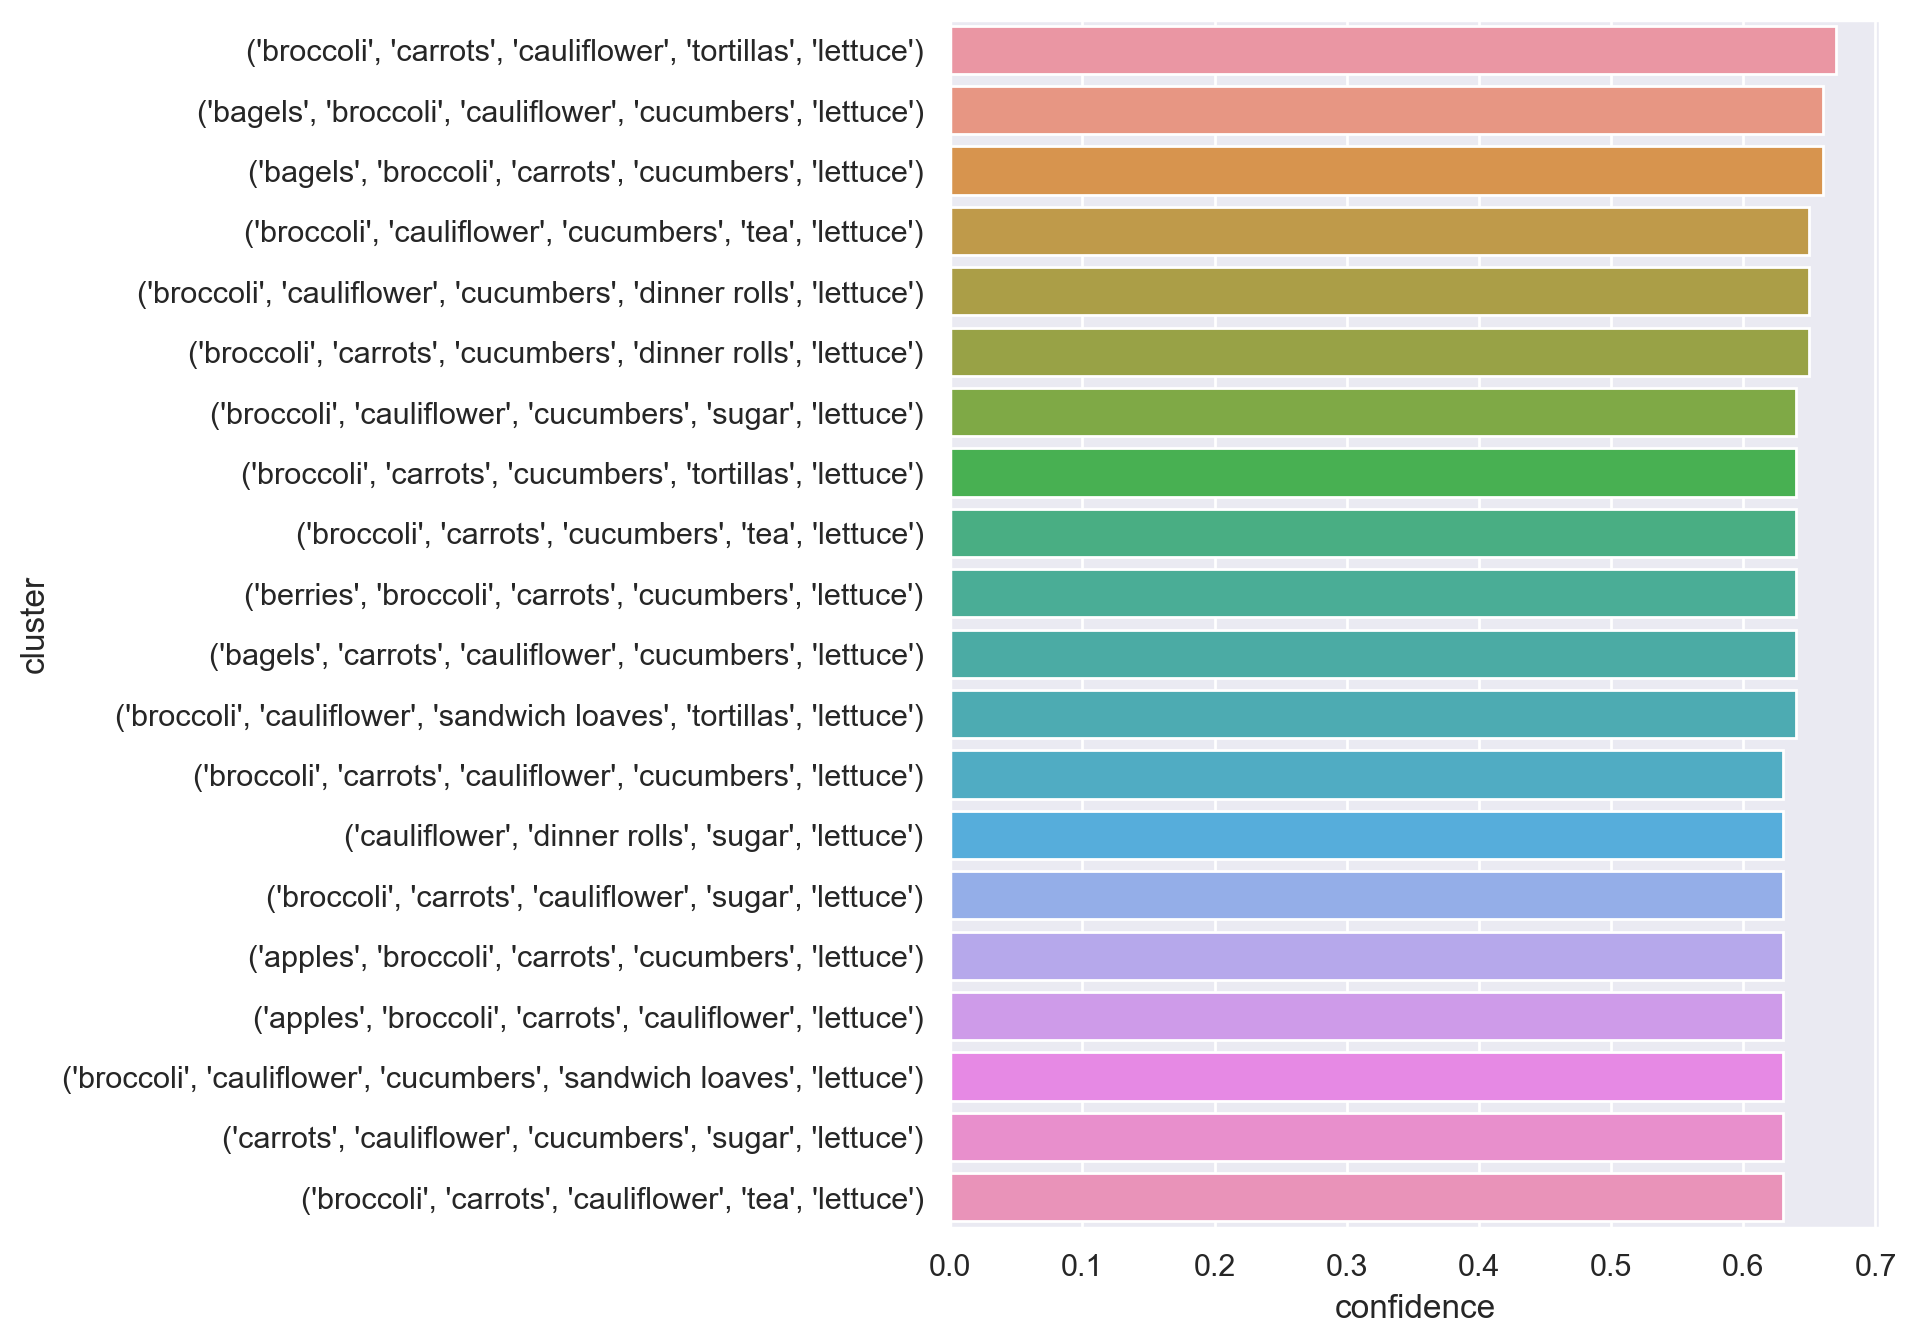

In [51]:
fig, ax = plt.subplots(figsize=(6, 8))
set_matplotlib_formats('retina')
sns.barplot(data=clusters_df.head(20), x='confidence', y='cluster',orient='h', ax=ax);